In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
np.set_printoptions(suppress=True,linewidth=np.inf)
import warnings
warnings.filterwarnings('ignore')

# 数据读取
data = pd.read_csv('../Loading_Results.csv')  # 修改路径
input_features = [f'LP{i}-{d}' for i in range(1, 5) for d in ['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz']]
output_feature = 'Knuckle_S'

X = data[input_features].values
y = data[[output_feature]].values.reshape(-1, 1)



(120, 372)
(3)SeedDataSplit found: 0-----TrainR²-+   0.9796557006029656   --TestR²--+  0.8428706441626556
[225.86]
[248.81847]


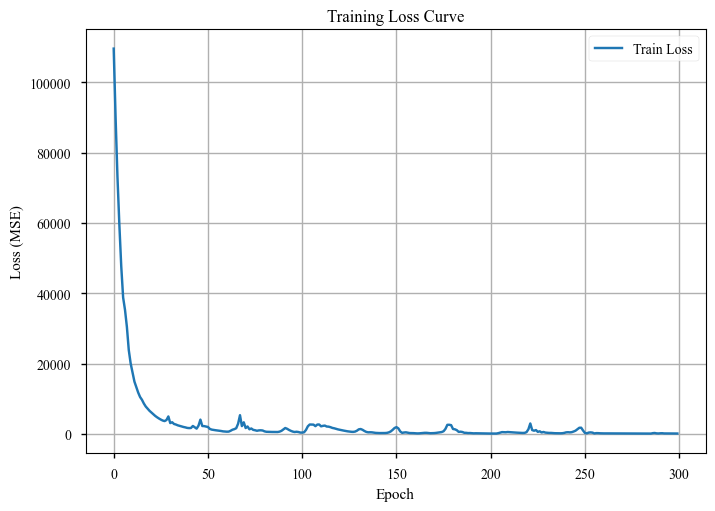

In [16]:
target = 0.99  # 假设你得到这个随机数（约值）
tolerance = 0.99
for seed1 in np.arange(1): 
        # 特征构造函数
    def NL(x, DegreePoly, DegreeSin, DegreeCos):
        poly = PolynomialFeatures(degree=DegreePoly, include_bias=False)
        x_poly = poly.fit_transform(x) if DegreePoly > 0 else x
        x_sin = np.hstack([np.sin((i + 1)/515 * x) for i in range(DegreeSin)]) if DegreeSin > 0 else None
        x_cos = np.hstack([np.cos((i + 1)/515 * x) for i in range(DegreeCos)]) if DegreeCos > 0 else None     #二阶515  #一阶3000
        x_final = x_poly
        if x_sin is not None:
            x_final = np.hstack([x_final, x_sin])
        if x_cos is not None:
            x_final = np.hstack([x_final, x_cos])
        return x_final

    # 参数设置
    DegreePoly = 2
    DegreeSin = 1
    DegreeCos = 1

    # 特征扩展与标准化
    X_feat = NL(X, DegreePoly, DegreeSin, DegreeCos)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feat)
    print(X_scaled.shape)
    
    # 划分数据
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=6203)         # 6203

    # 构建 MLP 网络模型
    #常用激活函数----'relu'；'sigmoid'；'tanh'；keras.layers.LeakyReLU(alpha=0.01);'selu';tf.nn.swish
    LayerModel = keras.Sequential([
        keras.layers.Dense(24, activation='selu',           
                           input_dim=X_train.shape[1],
                           kernel_regularizer=keras.regularizers.l2(8.9),             #二阶8.9       一阶0.51
                           kernel_initializer=tf.keras.initializers.GlorotUniform(seed=int(393)),#二阶393    一阶92
                           bias_initializer= keras.initializers.RandomNormal(mean=0.0, stddev=2, seed=int(76))),   # 二阶76    一阶300   
                           #隐藏层第1层；sequential顺序堆叠 dense全连接模型；activation激活函数
        keras.layers.Dropout(0,seed=999),                  #随机不更新神经元比例，防止过拟合                        
        keras.layers.Dense(1,
                           kernel_initializer=tf.keras.initializers.GlorotUniform(seed=int(1058)),#二阶1058      #一阶1439
                           bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=2, seed=int(664))) ##一阶664     
                           # 输出层   回归任务在输出层无类似softmax的激活函数
    ])

    # 编译模型
    tf.random.set_seed(48)      #一阶48
    LayerModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.06),  ##一阶0.06
                  loss='mse',               #损失函数
                  metrics=['mae'])          #仅仅是记录评价

    # 训练模型
    from scipy.stats import weibull_min
    stress_train = y_train[:, 0]
    k = 100                              #二阶100 一阶73
    λ = np.percentile(stress_train, 95)
    weibull_probs = weibull_min.cdf(stress_train, c=k, scale=λ)
    w_stress = (1 + 9.9 * weibull_probs).reshape(-1,1)  # 二阶9.9   一阶0.4

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    BPTrainedModel = LayerModel.fit(X_train, y_train,
                        epochs=300,     #二阶303
                        batch_size=40,  #一阶40
                        sample_weight = w_stress,
                        validation_split=0, #和早停一起用的，训练集中剥离多少百分比当做验证集，验证集只做验证操作，验证集的损失连续15步没有降低或者增大，就取最好的那一步
                        callbacks=[early_stop],
                        verbose=0)

    # 评估模型
    y_pred_test = LayerModel.predict(X_test,verbose=0)
    y_pred_train = LayerModel.predict(X_train,verbose=0)

    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_train, y_pred_train)

    #if abs(r2_test - target) < tolerance:
    print(f"(3)SeedDataSplit found: {seed1}-----TrainR²-+   {r2_train}   --TestR²--+  {r2_test}")

print(y[0]);print(y_pred_train[0])

# 可视化损失曲线
plt.plot(BPTrainedModel.history['loss'], label='Train Loss')
#plt.plot(BPTrainedModel.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

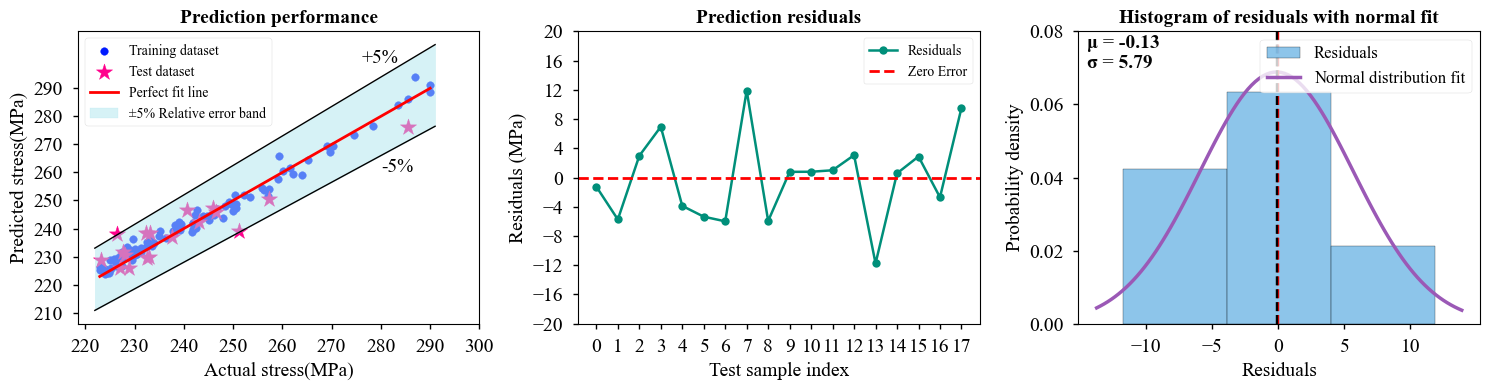

In [17]:
# 重新导入所需库和重新绘图
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

# 模拟 y_test 与 y_pred（用户应替换为真实数据）

# 1️⃣ 真实值 vs 预测值散点图
plt.figure(figsize=(15, 4),dpi=100);plt.subplot(131)
plt.scatter(y_train.ravel(), y_pred_train.ravel(), alpha=1,marker='o',color="#001AFF",s=30, label='Training dataset')
plt.scatter(y_test.ravel(), y_pred_test.ravel(), alpha=1,marker='*',color="#FF008C",s=150, label='Test dataset')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', lw=2, label='Perfect fit line')

y_train_generation=np.linspace(y_train.min()-1, y_train.max()+1, 100)
plt.plot(y_train_generation, y_train_generation * 1.05, 'k-', linewidth=1)
plt.plot(y_train_generation, y_train_generation* 0.95, 'k-', linewidth=1)
plt.fill_between(y_train_generation, y_train_generation * 1.05,y_train_generation * 0.95, color="#AEE6EE", alpha=0.5, label='±5% Relative error band')
# 标注文字
mid_idx = len(y_train) // 2
plt.text(276, 280 * 1.05+5 , '+5%', fontsize=14)
plt.text(280, 280 * 0.95-6, '-5%', fontsize=14)

plt.xlabel('Actual stress(MPa)',fontsize=14)
plt.ylabel('Predicted stress(MPa)',fontsize=14)
plt.title('Prediction performance',fontsize=14, fontweight='bold')
plt.legend(loc='upper left',fontsize=10)
plt.xticks(np.arange(220,310,10),fontsize=14);plt.yticks(np.arange(210,300,10),fontsize=14)
plt.tight_layout()
plt.grid(False)

# 2️⃣ 残差图（Residuals）
residuals = y_test.ravel() - y_pred_test.ravel()
plt.subplot(132)
plt.plot(residuals, marker='o', linestyle='-', color="#008f7a",label='Residuals', linewidth=1.8, markersize=6)
plt.axhline(0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Prediction residuals', fontsize=14, fontweight='bold')
plt.xlabel('Test sample index', fontsize=14)
plt.ylabel('Residuals (MPa)', fontsize=14)
plt.xticks(np.arange(0,18,1),fontsize=14);plt.yticks(np.arange(-20,21,4),fontsize=14)
plt.legend(frameon=True)
plt.tight_layout()
plt.grid(False)

# 3️⃣ 误差分布直方图
import scipy.stats as stats
# 使用 matplotlib 的默认样式
plt.style.use('seaborn-v0_8-notebook')  # 或使用其他内置样式，如 'bmh', 'seaborn', 'classic' 等
# 绘制残差的直方图
plt.subplot(133)
plt.hist(residuals,bins=3, edgecolor='k', alpha=0.7, density=True, color='#5DADE2', label='Residuals')  # 更自然的蓝色
# 绘制正态分布曲线
mu, std = np.mean(residuals), np.std(residuals)
x = np.linspace(residuals.min()-2, residuals.max()+2, 100)  # 生成x轴数据点
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))  # 正态分布拟合
plt.plot(x, p, linestyle='-',lw=2.5,color="#9B59B6" ,label='Normal distribution fit')  # 使用红色进行拟合曲线
plt.axvline(0, color='red', linestyle='--')
plt.axvline(mu, color='k', linestyle='--')
# 添加标签和标题
plt.text(-14.5, 0.07, f'μ = {mu:.2f}\nσ = {std:.2f}',color="#050505" ,fontweight='bold',fontsize=14)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.title('Histogram of residuals with normal fit', fontsize=14,fontweight='bold')
plt.xticks(np.arange(-10,11,5),fontsize=14)  # x轴刻度字体增大
plt.yticks(np.arange(0,0.1,0.02),fontsize=14)  # y轴刻度字体增大
plt.legend(loc='upper right',fontsize=12) # 显示图例并增加字体大小

plt.tight_layout()
plt.savefig("Fig15(h)-Predictive accuracy and error distribution.svg", dpi=600, bbox_inches='tight')
plt.show()


In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 假设你已有：
# y_test: 真实值（真实目标输出）
# y_predict_test_bgd: 模型预测值

# ✅ MSE（均方误差）
mse = mean_squared_error(y_test, y_pred_test)

# ✅ RMSE（均方根误差）
rmse = np.sqrt(mse)

# ✅ MAE（平均绝对误差）
mae = mean_absolute_error(y_test, y_pred_test)

# ✅ MAPE（平均绝对百分比误差）
# 为避免除以0，加入一个较小的 epsilon
epsilon = 1e-8
mape = np.mean(np.abs((y_test - y_pred_test) / (y_test + epsilon))) * 100

# ✅ RAE（相对绝对误差）
rae = np.sum(np.abs(y_test - y_pred_test)) / np.sum(np.abs(y_test - np.mean(y_test)))

# ✅ R²（决定系数）
from sklearn.metrics import r2_score
r2_bgd = r2_score(y_test, y_pred_test)

# ✅ 输出全部指标
print(f"R²       : {r2_bgd:.5f}")
print(f"MSE      : {mse:.5f}")
print(f"RMSE     : {rmse:.5f}")
print(f"MAE      : {mae:.5f}")
print(f"MAPE (%) : {mape:.2f}%")
print(f"RAE      : {rae:.5f}")


R²       : 0.84287
MSE      : 33.56903
RMSE     : 5.79388
MAE      : 4.61211
MAPE (%) : 1.91%
RAE      : 0.42239
